<a href="https://colab.research.google.com/github/mnjkhtri/brain-tumor-detection-and-localization/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **EDA and Preprocessing**

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
DATA_PATH = "/content/drive/MyDrive/ColabNotebooks/kaggle_3m/"

In [4]:
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)


df = pd.DataFrame(
    {"dirname" : data_map[::2], "path" : data_map[1::2]}
)

df.head()

This is not a dir: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/README.md
This is not a dir: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/data.csv
This is not a dir: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/base_df.csv


,dirname,path
0,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
1,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
2,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
3,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...
4,TCGA_DU_7306_19930512,/content/drive/MyDrive/ColabNotebooks/kaggle_3...


In [5]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

BASE_LEN = len(df_imgs['path'].values[0]) - len('xx.tif')
END_IMG_LEN = -len('.tif')
END_MASK_LEN = -len('xmask.tif')

In [6]:
df_imgs['path'].values[0][BASE_LEN:END_IMG_LEN], df_masks['path'].values[0][BASE_LEN:END_MASK_LEN]

('14', '16')

In [7]:
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:END_MASK_LEN]))

In [8]:
# Sorting check
idx = np.random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_1.tif 
Path to the Mask: /content/drive/MyDrive/ColabNotebooks/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_1_mask.tif


In [ ]:
df = pd.DataFrame(
    {"patient": df_imgs.dirname.values, "image_path": imgs, "mask_path": masks}
)

def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path)) #loads as a numpy array
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))

KeyboardInterrupt: ignored

In [9]:
df = pd.read_csv(DATA_PATH+'base_df.csv')

In [10]:
df['diagnosis'].sum()

1373

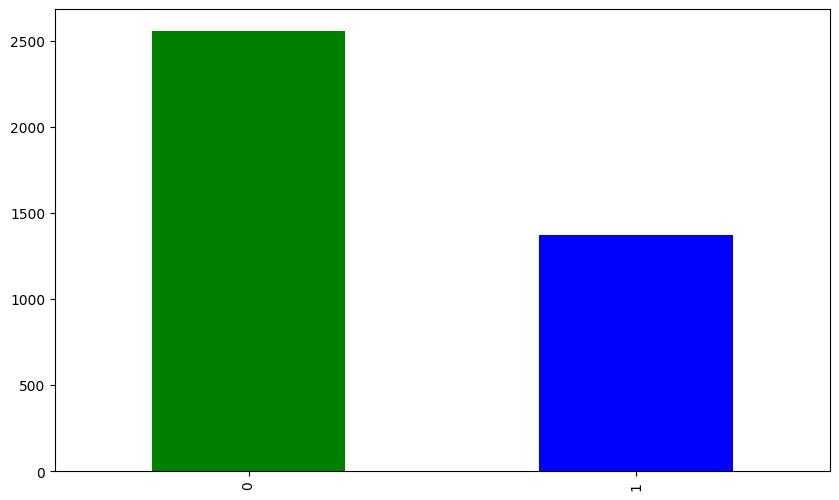

In [11]:
ax = df.diagnosis.value_counts().plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=["green", "blue"]
)

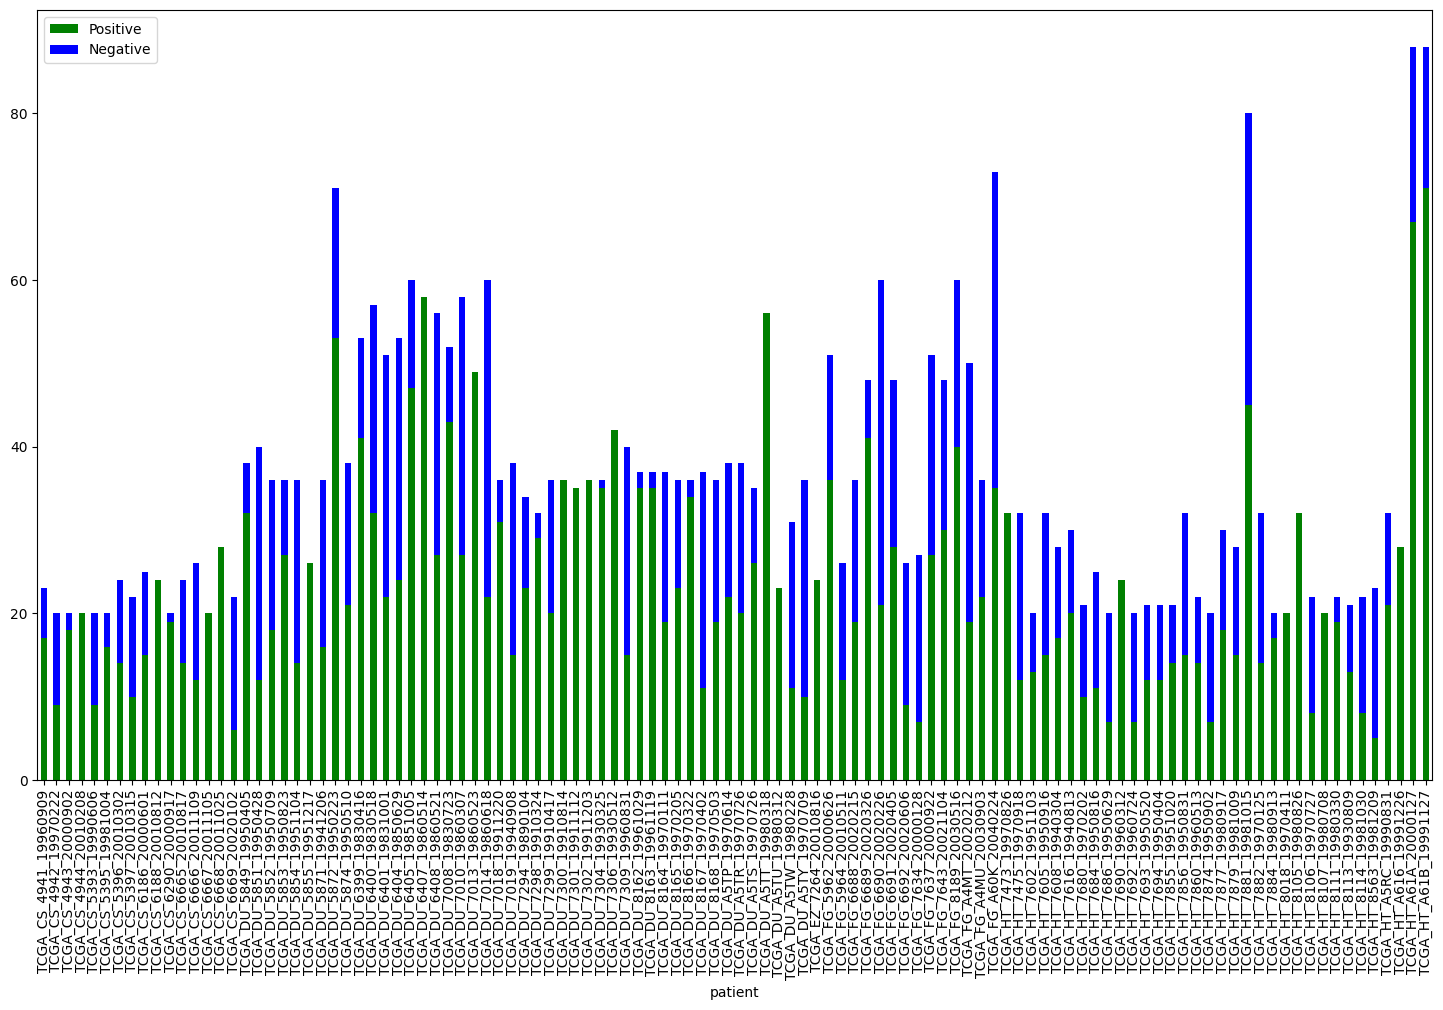

In [12]:
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

ax = patients_by_diagnosis.plot(
    kind='bar',
    stacked=True,
    figsize=(18, 10),
    color=["green", "blue"],
)

In [13]:
IMG_SIZE = 512

sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    #Both img and mask are from 0 to 255 as int8 as they should be
    sample_imgs.extend([img, mask])

In [14]:
sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

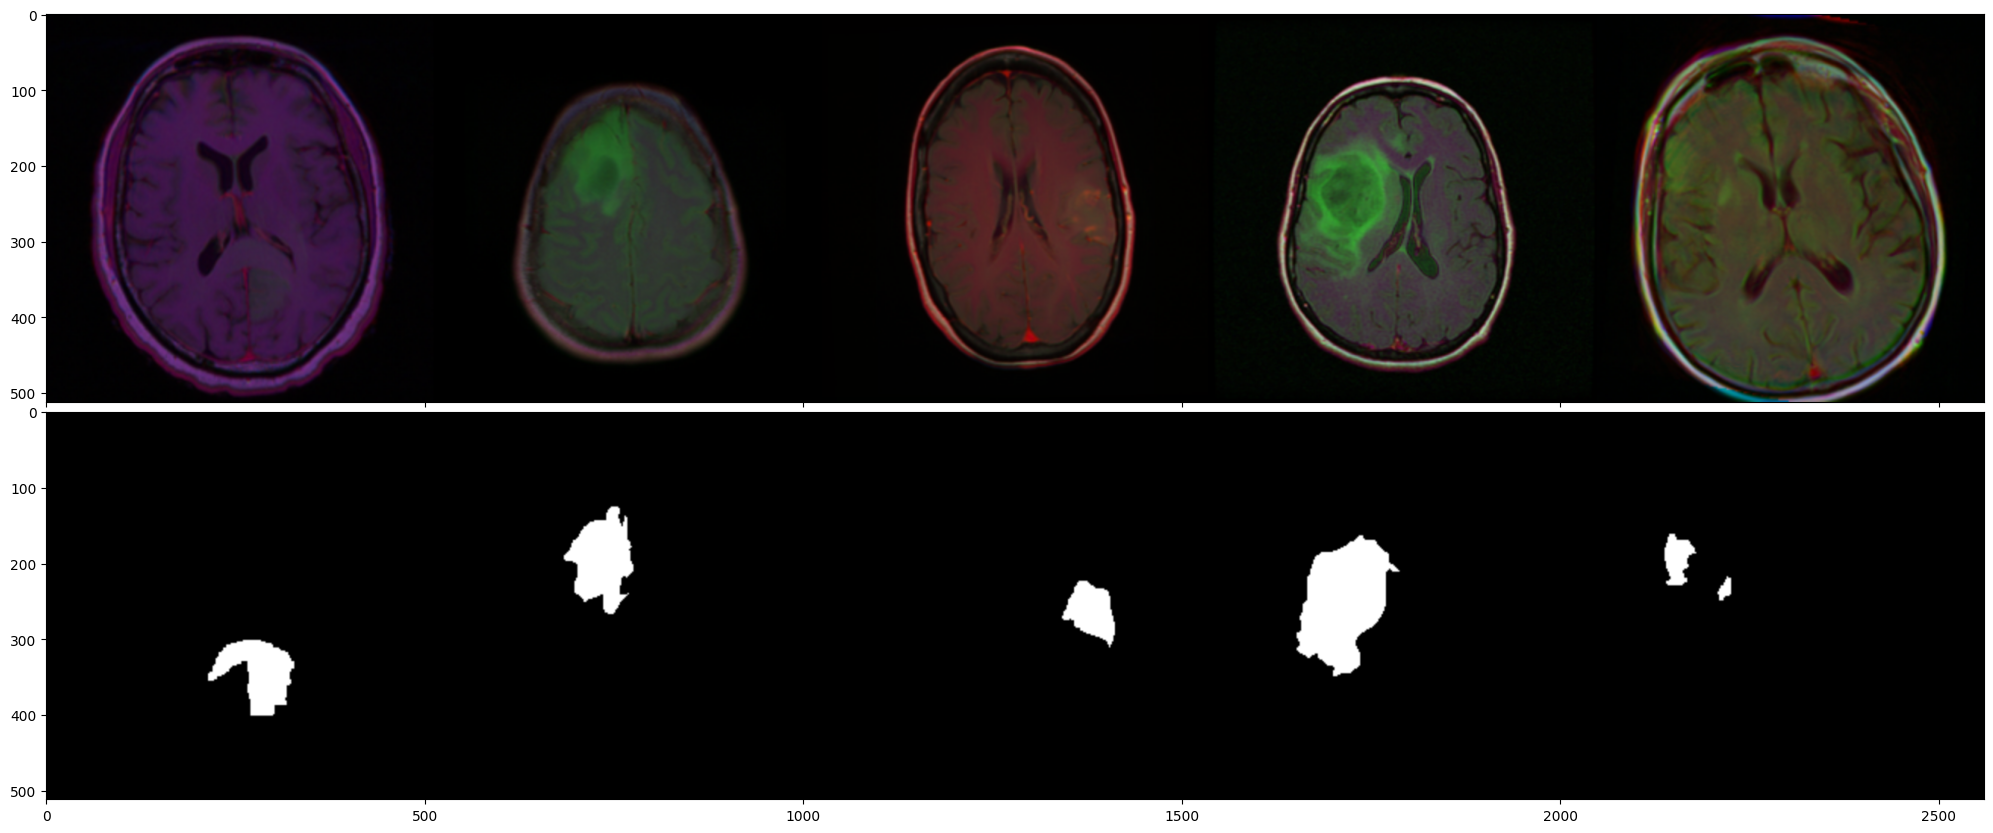

In [15]:
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 1), axes_pad=0.1)

grid[0].imshow(sample_imgs_arr)
grid[1].imshow(sample_masks_arr)

# **Augmentation**

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

In [17]:
df.iloc[10, 1]

'/content/drive/MyDrive/ColabNotebooks/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_1.tif'

In [18]:

class BrainMriDataset(Dataset):
    def __init__(self, df, transforms):

        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 1]) #Default mode
        mask = cv2.imread(self.df.iloc[idx, 2], 0) #Grayscale mode

        augmented = self.transforms(image=image, mask=mask)
        #Albumentations donot apply normalization to the mask so it is still float32

        image = augmented['image']
        mask = augmented['mask']/255 #Gotta normalize myself

        return image, mask

In [19]:
PATCH_SIZE = 128#256


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.05, rotate_limit=0, p=0.25),


    A.Normalize(p=1.0),
    ToTensorV2(),
])

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.05, rotate_limit=0, p=0.25),

    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.IAAEmboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),

    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120*0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    ], p=0.8),


    A.Normalize(p=1.0),
    ToTensorV2(),
])

/usr/local/lib/python3.10/dist-packages/albumentations/imgaug/transforms.py:176: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Emboss instead", FutureWarning)


In [20]:
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [21]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=2, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=2, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=2, shuffle=True)

In [22]:
for batch, labels in train_dataloader:
  print(batch.shape, labels.shape)
  print(batch.dtype, labels.dtype)
  print(batch.min(), labels.min())
  print(batch.max(), labels.max())
  break

torch.Size([26, 3, 128, 128]) torch.Size([26, 128, 128])
torch.float32 torch.float32
tensor(-2.1179) tensor(0.)
tensor(2.3936) tensor(1.)


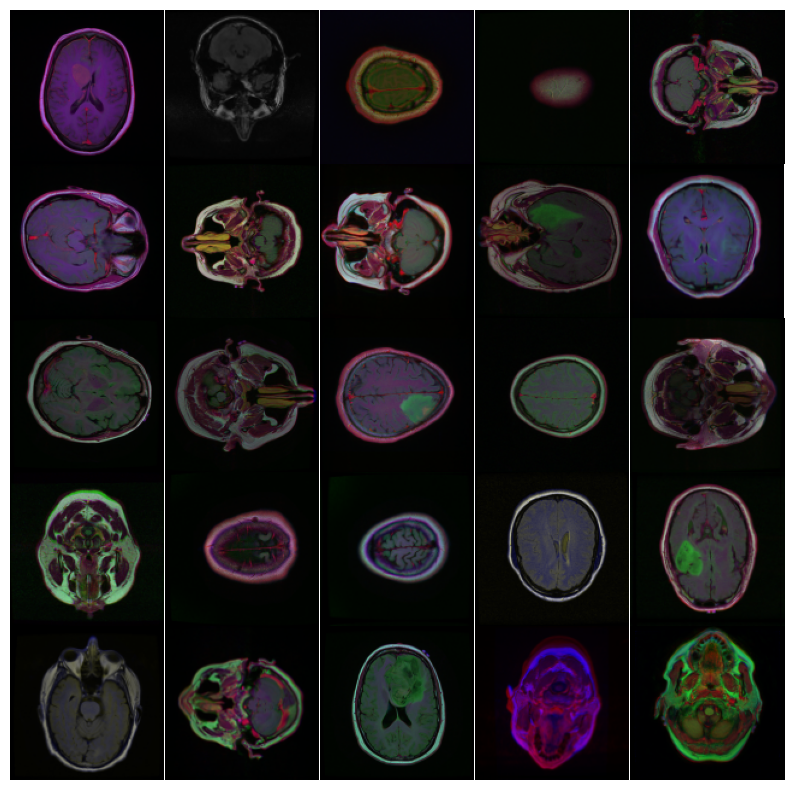

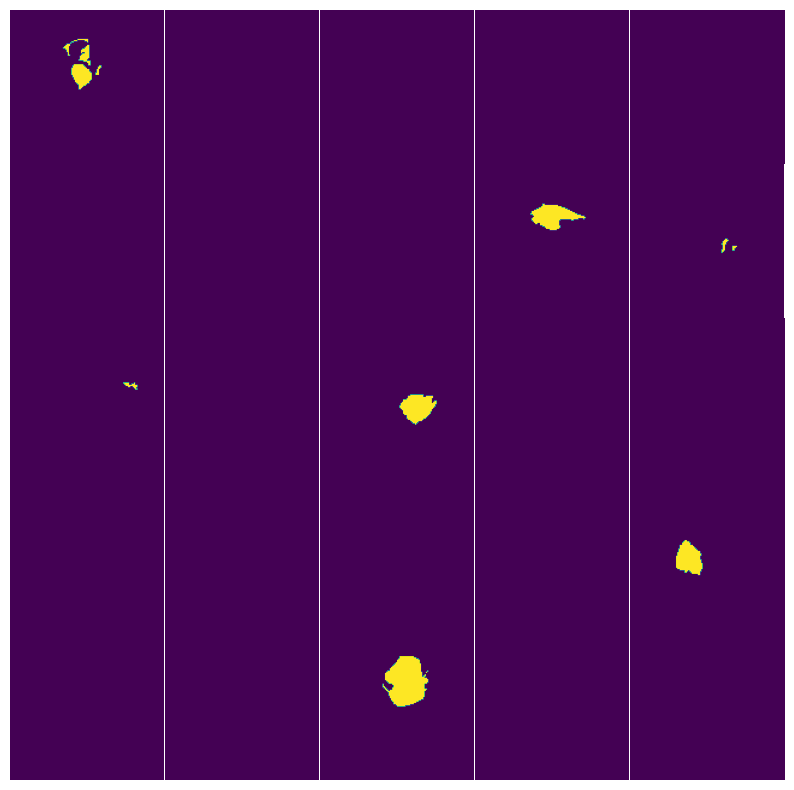

In [23]:
def show_aug(inputs, nrows=5, ncols=5, image=True):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0

    if len(inputs) > 25:
        inputs = inputs[:25]

    for idx in range(len(inputs)):

        # normalization
        if image is True:
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225]
            img = (img*std+mean).astype(np.float32)
            img = np.clip(img, 0, 1)
        else:
            img = inputs[idx].numpy().astype(np.float32)


        plt.subplot(nrows, ncols, i_+1)
        plt.axis('off')
        plt.imshow(img);

        i_ += 1

    plt.show()


images, masks = next(iter(train_dataloader))

show_aug(images)
show_aug(masks, image=False)

# **Training**

In [24]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))

In [57]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = double_conv(256 + 512, 256)
        self.conv_up2 = double_conv(128 + 256, 128)
        self.conv_up1 = double_conv(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)


    def forward(self, x):
        # Batch - 1d tensor.  N_channels - 1d tensor, IMG_SIZE - 2d tensor.
        # Example: x.shape >>> (10, 3, 256, 256).

        conv1 = self.conv_down1(x)  # <- BATCH, 3, IMG_SIZE  -> BATCH, 64, IMG_SIZE..
        x = self.maxpool(conv1)     # <- BATCH, 64, IMG_SIZE -> BATCH, 64, IMG_SIZE 2x down.
        conv2 = self.conv_down2(x)  # <- BATCH, 64, IMG_SIZE -> BATCH,128, IMG_SIZE.
        x = self.maxpool(conv2)     # <- BATCH, 128, IMG_SIZE -> BATCH, 128, IMG_SIZE 2x down.
        conv3 = self.conv_down3(x)  # <- BATCH, 128, IMG_SIZE -> BATCH, 256, IMG_SIZE.
        x = self.maxpool(conv3)     # <- BATCH, 256, IMG_SIZE -> BATCH, 256, IMG_SIZE 2x down.
        x = self.conv_down4(x)      # <- BATCH, 256, IMG_SIZE -> BATCH, 512, IMG_SIZE.
        x = self.upsample(x)        # <- BATCH, 512, IMG_SIZE -> BATCH, 512, IMG_SIZE 2x up.

        #(Below the same)                                 N this       ==        N this.  Because the first N is upsampled.
        x = torch.cat([x, conv3], dim=1) # <- BATCH, 512, IMG_SIZE & BATCH, 256, IMG_SIZE--> BATCH, 768, IMG_SIZE.

        x = self.conv_up3(x) #  <- BATCH, 768, IMG_SIZE --> BATCH, 256, IMG_SIZE.
        x = self.upsample(x)  #  <- BATCH, 256, IMG_SIZE -> BATCH,  256, IMG_SIZE 2x up.
        x = torch.cat([x, conv2], dim=1) # <- BATCH, 256,IMG_SIZE & BATCH, 128, IMG_SIZE --> BATCH, 384, IMG_SIZE.

        x = self.conv_up2(x) # <- BATCH, 384, IMG_SIZE --> BATCH, 128 IMG_SIZE.
        x = self.upsample(x)   # <- BATCH, 128, IMG_SIZE --> BATCH, 128, IMG_SIZE 2x up.
        x = torch.cat([x, conv1], dim=1) # <- BATCH, 128, IMG_SIZE & BATCH, 64, IMG_SIZE --> BATCH, 192, IMG_SIZE.

        x = self.conv_up1(x) # <- BATCH, 128, IMG_SIZE --> BATCH, 64, IMG_SIZE.

        out = self.last_conv(x) # <- BATCH, 64, IMG_SIZE --> BATCH, n_classes, IMG_SIZE.
        out = torch.sigmoid(out)

        return out

In [25]:
class UNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        #Trainables:
        self.conv_down1 = double_conv(3, 64)
        self.conv_down2 = double_conv(64, 128)
        self.conv_down3 = double_conv(128, 256)
        self.conv_down4 = double_conv(256, 512)

        #Trainables:
        self.conv_up3 = double_conv(512 + 256, 256)
        self.conv_up2 = double_conv(256 + 128, 128)
        self.conv_up1 = double_conv(128 + 64, 64)

        self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)

        #Non trainables:
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        #BATCH * 3 * IMG_SIZE

        conv1 = self.conv_down1(x)
        #BATCH * 64 * IMG_SIZE/1
        x = self.maxpool(conv1)
        #BATCH * 64 * IMG_SIZE/2

        conv2 = self.conv_down2(x)
        #BATCH * 128 * IMG_SIZE/2
        x = self.maxpool(conv2)
        #BATCH * 128 * IMG_SIZE/4

        conv3 = self.conv_down3(x)
        #BATCH * 256 * IMG_SIZE/4
        x = self.maxpool(conv3)
        #BATCH * 256 * IMG_SIZE/8

        x = self.conv_down4(x)
        #BATCH * 512 * IMG_SIZE/8

        x = self.upsample(x)
        #BATCH * 512 * IMG_SIZE/4

        x = torch.cat([x, conv3], dim=1)
        #BATCH * (512 + 256) * IMG_SIZE/4

        x = self.conv_up3(x)
        #BATCH * (256) * IMG_SIZE/4
        x = self.upsample(x)
        #BATCH * (256) * IMG_SIZE/2

        x = torch.cat([x, conv2], dim=1)
        #BATCH * (256 + 128) * IMG_SIZE/2

        x = self.conv_up2(x)
        #BATCH * (128) * IMG_SIZE/2
        x = self.upsample(x)
        #BATCH * (128) * IMG_SIZE

        x = torch.cat([x, conv1], dim=1)
        #BATCH * (128 + 64) * IMG_SIZE

        x = self.conv_up1(x)
        #BATCH * (64) * IMG_SIZE

        out = self.last_conv(x)
        #BATCH * (n_classes) * IMG_SIZE

        out = torch.sigmoid(out)
        return out

In [58]:
unet = UNet(n_classes=1)
output = unet(torch.randn(1,3,256,256))
print(output.shape, output.dtype)

#Our labels shape was something different

torch.Size([1, 1, 256, 256]) torch.float32


In [34]:
from torchvision.models import resnext50_32x4d

class ConvRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, padding):
        super().__init__()

        self.convrelu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.convrelu(x)
        return x

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = ConvRelu(in_channels, in_channels // 4, 1, 0)

        self.deconv = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, kernel_size=4,
                                          stride=2, padding=1, output_padding=0)

        self.conv2 = ConvRelu(in_channels // 4, out_channels, 1, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.deconv(x)
        x = self.conv2(x)

        return x

In [35]:
class ResNeXtUNet(nn.Module):

    def __init__(self, n_classes):
        super().__init__()

        self.base_model = resnext50_32x4d(pretrained=True)
        self.base_layers = list(self.base_model.children())
        filters = [4*64, 4*128, 4*256, 4*512]

        # Down
        self.encoder0 = nn.Sequential(*self.base_layers[:3])
        self.encoder1 = nn.Sequential(*self.base_layers[4])
        self.encoder2 = nn.Sequential(*self.base_layers[5])
        self.encoder3 = nn.Sequential(*self.base_layers[6])
        self.encoder4 = nn.Sequential(*self.base_layers[7])

        # Up
        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        # Final Classifier
        self.last_conv0 = ConvRelu(256, 128, 3, 1)
        self.last_conv1 = nn.Conv2d(128, n_classes, 3, padding=1)


    def forward(self, x):
        # Down
        x = self.encoder0(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Up + sc
        d4 = self.decoder4(e4) + e3
        d3 = self.decoder3(d4) + e2
        d2 = self.decoder2(d3) + e1
        d1 = self.decoder1(d2)
        #print(d1.shape)

        # final classifier
        out = self.last_conv0(d1)
        out = self.last_conv1(out)
        out = torch.sigmoid(out)

        return out

In [36]:
rx50 = ResNeXtUNet(n_classes=1).to(device)
output = rx50(torch.randn(1,3,256,256).to(device))
print(output.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 89.8MB/s]


torch.Size([1, 1, 256, 256])


In [59]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

unet.to(device)
rx50.to(device)

ResNeXtUNet(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample)

# **Metric and Loss**

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda', index=0)

In [29]:
#For one batch or so:

def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    return intersection / union

#For the whole valid data set:

def compute_iou(model, loader, threshold=0.3):
    valloss = 0

    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):

            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            out_cut = np.copy(outputs.squeeze().cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.cpu().numpy())
            valloss += picloss

    return valloss / i_step

In [30]:
#For one batch or so:

def bce_dice_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth
    dicescore = 1 - (intersection / union)
    #DL(y,p) = 1-(2yp+1)/(y+p+1)

    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss+dicescore

#Loss Check
for (data, target) in train_dataloader:
    data = data.to(device)
    target = target.to(device)

    outputs = unet(data)

    loss = bce_dice_loss(outputs.squeeze(), target)
    print(loss)
    break

tensor(1.6407, device='cuda:0', grad_fn=<AddBackward0>)


In [60]:
#We will track the following:

"""

For losses
1. Mean Loss of Each Train Batch
2. Metric of Each Train Batch
3. Metric of Valid Set after Each Epoch

"""

def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, num_epochs):

    print(model_name)

    loss_history = []
    train_metric = []
    valid_metric = []

    for epoch in range(num_epochs):
        model.train() #Train mode

        losses = []
        trains = []

        for i_step, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            #Dont do tensor.data do tensor.detach()
            out_cut = np.copy(outputs.squeeze().detach().cpu().numpy())
            out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.5)] = 1.0

            train_dice = dice_coef_metric(out_cut, target.detach().cpu().numpy())

            trains.append(train_dice)

            #Output has one extra dimension?
            loss = train_loss(outputs.squeeze(), target)

            losses.append(loss.detach().cpu())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Epoch [%d]" % (epoch))

        epoch_loss = np.array(losses).mean()
        epoch_train_metric = np.array(trains).mean()
        epoch_valid_metric = compute_iou(model, val_loader)

        print(
              "Mean LOSS on train:", epoch_loss,
              "\nMean DICE on train:", epoch_train_metric,
              "\nMean DICE on validation:", epoch_valid_metric
        )

        loss_history.append(epoch_loss)
        train_metric.append(epoch_train_metric)
        valid_metric.append(epoch_valid_metric)

    return loss_history, train_metric, valid_metric

In [ ]:
unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)
rx50_optimizer = torch.optim.Adam(rx50.parameters(), lr=5e-4)

num_ep = 10
unet_lh, unet_th, unet_vh = train_model("UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, 10)


# rx50_lh, rx50_th, rx50_vh = train_model("ResNeXt50", rx50, train_dataloader, val_dataloader, bce_dice_loss, rx50_optimizer, num_ep)

UNet
Epoch [0]
Mean LOSS on train: 0.7873216 
Mean DICE on train: 0.2593183024820339 
Mean DICE on validation: 0.4869105449768016
Epoch [1]
Mean LOSS on train: 0.61529756 
Mean DICE on train: 0.47250473501481466 
Mean DICE on validation: 0.5356004564579381
Epoch [2]
Mean LOSS on train: 0.5611196 
Mean DICE on train: 0.5129741036957947 
Mean DICE on validation: 0.5398153434568004
Epoch [3]
Mean LOSS on train: 0.52132803 
Mean DICE on train: 0.5486600235818356 
Mean DICE on validation: 0.5987859179838624
Epoch [4]
Mean LOSS on train: 0.4591482 
Mean DICE on train: 0.5988202724275505 
Mean DICE on validation: 0.6120797204177282
Epoch [5]
Mean LOSS on train: 0.44729945 
Mean DICE on train: 0.6086977301439049 
Mean DICE on validation: 0.716608809480124
Epoch [6]
Mean LOSS on train: 0.40691525 
Mean DICE on train: 0.6427967864211215 
Mean DICE on validation: 0.7326815309735993
Epoch [7]
Mean LOSS on train: 0.39608 
Mean DICE on train: 0.6517719634688037 
Mean DICE on validation: 0.7528554291

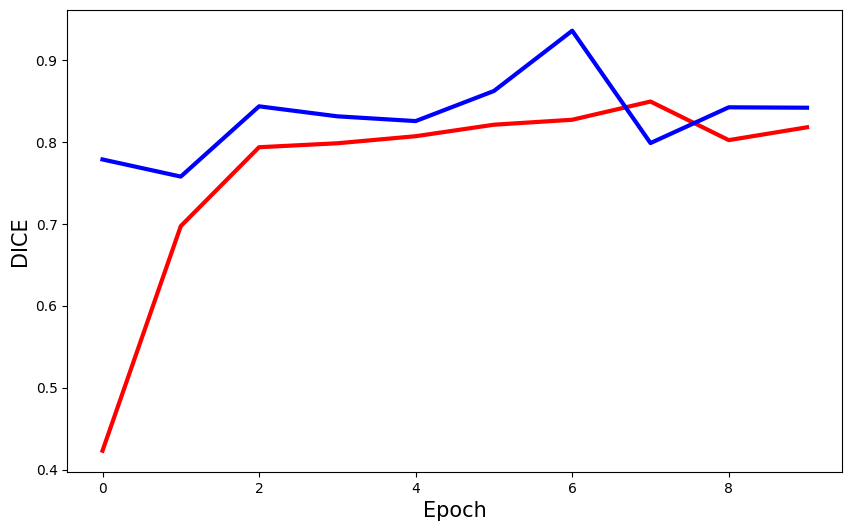

In [43]:
def plot_model_history(model_name, train_history, val_history, num_epochs):
    fig = plt.figure(figsize=(10, 6))
    x = np.arange(num_epochs)
    plt.plot(x, train_history, label='train dice', lw=3, c="red")
    plt.plot(x, val_history, label='validation dice', lw=3, c="blue")
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)
    plt.show()

# plot_model_history("UNet with ResNeXt50 backbone", unet_th, unet_vh, num_ep)
# rx50_lh, rx50_th, rx50_vh
plot_model_history("UNet with ResNeXt50 backbone", rx50_th, rx50_vh, num_ep)


In [ ]:
print(unet_th)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


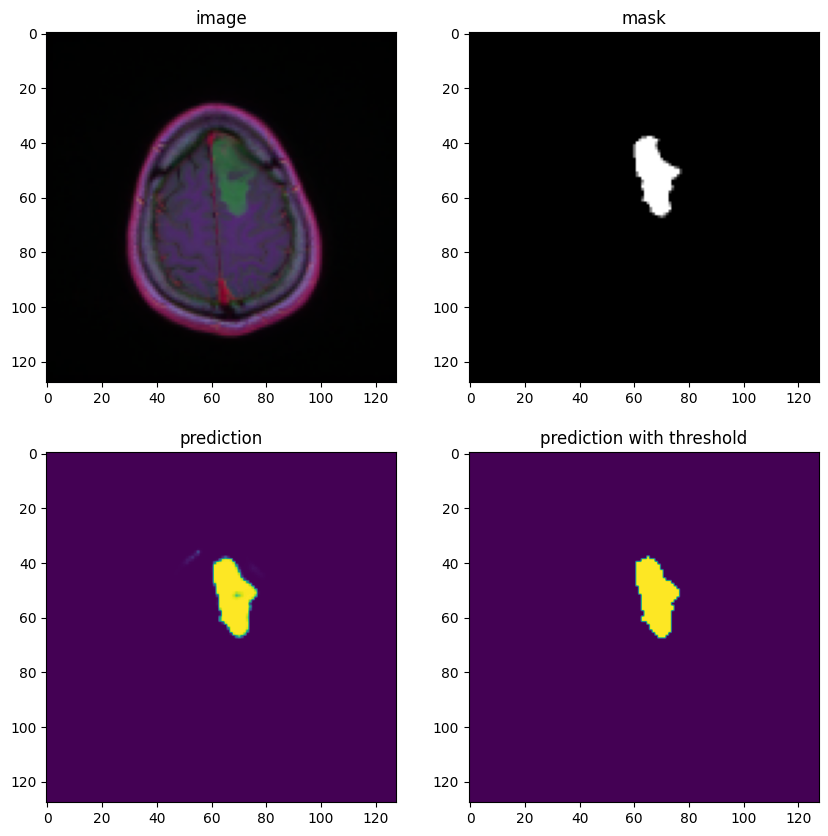

In [56]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = rx50(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()